 <h1 style="text-align:center"> ECX Case Study </h1>

**Business problems and challenges:**

Management have just advised that we have 110 “2018 4runner trd pro” being returned today, they are all in good condition with average km's for their age.

Management is trying to understand what is the sale price we can get for these vehicles along with any other factors they should consider in the sale.

**Solution**

The company has provided previous selling dataset, including sales information of different types of Toyota cars. We can build a model to predict the price of a specific type of car. We can look this as a regression problem.  

The main process of implementing the problem could be divided into the following steps:

 - Data cleaning

 - Feature engineering

 - Modelling


## 1. Data Overview

The dataset comprises 17 columns with 23549 rows entries:
- `id`: each car has a unique recording id.
- `price`: sold price.
- `year`: the manufactured year of the car.
- `manufacturer`: vehicle manufacturer. In this dataset, all cars are from Toyota company.
- `model`: vehicle model.
- `condition`: vehicle's condition, including excellent, like new, etc. 
- `odometer`: vehicle's odometer number when sold.
- `title_status`: such as rebuilt, lien, missing, etc.
- `transmission`
- `VIN`: vehcile identification number
- `drive`: includes 4wd, rwd, fwd, etc.

Other information such as `fuel`, `cylinders`, `type`, `paint_color`, `size`, and `Sold_Date` also included in the dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV 
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from prettytable import PrettyTable

In [2]:
ecx_data = pd.read_excel('ECX data.xlsb',engine='pyxlsb')
ecx_data.head()

,id,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,Sold Date
0,29651,24914,2016,toyota,4runner,NaN,6 cylinders,gas,92966.0,clean,automatic,NaN,rwd,mid-size,SUV,white,2021-04-07T12:59:13-0500
1,29653,37995,2018,toyota,4runner,NaN,NaN,gas,38196.0,clean,automatic,JTEZU5JR9J5180715,NaN,NaN,SUV,white,2021-04-06T12:30:38-0500
2,29658,18605,2013,toyota,4runner,NaN,6 cylinders,gas,165859.0,clean,automatic,NaN,4wd,mid-size,SUV,black,2021-04-05T06:27:51-0500
3,29671,22950,2014,toyota,4runner,excellent,6 cylinders,gas,145160.0,clean,automatic,JTEBU5JR5E5155575,4wd,NaN,SUV,white,2021-05-04T15:30:20-0500
4,29699,24998,2013,toyota,4runner,NaN,6 cylinders,gas,99007.0,clean,automatic,NaN,rwd,mid-size,SUV,black,2021-05-04T10:11:27-0500


In [3]:
ecx_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23549 entries, 0 to 23548
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            23549 non-null  int64  
 1   price         23549 non-null  int64  
 2   year          23549 non-null  int64  
 3   manufacturer  23549 non-null  object 
 4   model         23549 non-null  object 
 5   condition     14359 non-null  object 
 6   cylinders     14750 non-null  object 
 7   fuel          23331 non-null  object 
 8   odometer      23308 non-null  float64
 9   title_status  23020 non-null  object 
 10  transmission  23387 non-null  object 
 11  VIN           15498 non-null  object 
 12  drive         17373 non-null  object 
 13  size          6358 non-null   object 
 14  type          19477 non-null  object 
 15  paint_color   16989 non-null  object 
 16  Sold Date     23549 non-null  object 
dtypes: float64(1), int64(3), object(13)
memory usage: 3.1+ MB


There are numerous missing values in the dataset, which can be shown in either the data info or the graph liseted below. Thus, we should handle the 'dirty' dataset first.

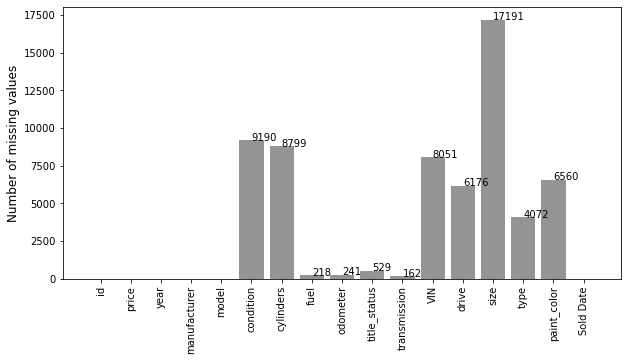

In [4]:
nulls = ecx_data.isnull().sum()
plt.figure(figsize=(10,5))
plt.bar(nulls.index, nulls , color='#929591')
plt.ylabel('Number of missing values',fontsize=12)
plt.xticks(rotation=90) 
for idx, val in nulls.iteritems():
    if val != 0:
        plt.text(idx, val, str(val), color='black')
plt.show()

## 2. Data cleaning

In this section, we will create a series of functions to complete the data cleaning task to improve the data quality, making it easier for following analysis.

According to research, Toyota has 16 different types of vehicle (such as 4Runner, Tacoma etc.), and each model has its different configurations (sub-model). To classify different vehicle models, we only use the main model type to represent all cars belonging to it. Meanwhile, if the selling records of a specific vehicle model is less than 30, we will remove these records as the ML model couldn't learn well when data size is considered small.

After cleaning the vehicle model, we can use the model and manufacture year to handle some missing values. Finally, we should remove some invalid entries to improve the data quality.

- **Pre-Processing the text feature**
  
  This analysis uses the main model name to represent all sub-models in order to make the 'model' feature neat. It 
  can also be useful to handle missing values whereas certain vehicle models with less than 30 selling records may be removed as  the ML model could not learn and predict well.
  

- **Handle missing values**

  We estimate that the same vehicle model manufactured in the same year are likely to have same cylinder configuration (4,6,8,etc.) and body type (such as SUV, sedan, truck, etc.). Using this method to fill some missing values. 
  
  If important field with missing value, it could be dropped. 
  

- **Reduce redundancy**

  Some entries are invalid such as the records with unreasonable `price` value (0, 100, or over 100,000, etc.)


### 2.1 Pre-processing text feature

In this section, the `model` column is cleaned by classifying model name into several main category, and removing some model sales information with less 30 records.

In [5]:
def model_name(string):
    toyota = ['tacoma','tundra','rav4','prius','sienna','4runner','86',
             'yaris','highlander','avalon','venza','fj cruiser','matrix',
              'sequoia','scion','mr2']
    string = re.sub('[^A-Za-z0-9\s]','',string)
    string = re.sub('\s+',' ',string)
    names = string.split()
    for name in names:
        for tya in toyota:
            if name in tya:
                string = tya
                break        
    return string

def drop_row(df):
    removed = []
    categories = df['clean_model'].value_counts()
    
    for idx, val in categories.iteritems():
        if val < 30:
            removed.append(idx)
            
    for idx, row in df.iterrows():
        if row['clean_model'] in removed:
            df.drop(idx, inplace=True)
            
    return df 

In [6]:
clean_model = ecx_data.copy()

clean_model['clean_model'] = clean_model['model'].apply(model_name)
clean_model = drop_row(clean_model)

### 2.2 Handle missing values

After cleaning the `model` column, we move on to clean the 'type' and 'drive' columns. According to research, cars manufactured in same year with same model may have same type and cylinders. Therefore, I filled the missing values in `cylinders` and `type` columns. 

Additionally, if the important feature `odometer` contains missing values, we will directly drop them.

In [7]:
def fill_type(df):
    n_df = df.dropna(subset=['type'])
    n_df = df.drop_duplicates(subset=['clean_model','year'])
    
    for idx, row in df.iterrows():
        if row['type'] is np.NaN:
            for i, r in n_df.iterrows():
                if r['year'] == row['year'] and r['clean_model']==row['clean_model']:
                    df.loc[idx,'type'] = n_df.loc[i,'type']
    return  df   


def fill_cyl(df):
    n_df = df.dropna(subset=['cylinders'])
    n_df = n_df.drop_duplicates(subset=['clean_model','year'])
    
    for idx, row in df.iterrows():
                     
        if row['cylinders'] is np.NaN:
            for i, r in n_df.iterrows():
                if r['year'] == row['year'] and r['clean_model'] == row['clean_model']:
                         df.loc[idx, 'cylinders'] = n_df.loc[i, 'cylinders']
    return df            
        

In [8]:
# fill missing type
clean_type = fill_type(clean_model)

# fill missing cylinders
clean_cyl = fill_cyl(clean_type)

# remove null values in odometer column
remove_null_odo = clean_cyl.dropna(subset=['odometer'])

clean_missing = remove_null_odo.copy()

### 2.3 Removing invalid entries

Since the `price` column is our target column, we need to remove records with unreasonable values. We set a rule that if the price value is less than 800 or over 100,000, these fields are unreasonable or invalid for the prediction model.

In [9]:
clean_df = clean_missing[(clean_missing['price'] >=800) & (clean_missing['price'] <100000)]

In [10]:
clean_df.reset_index(drop=True)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20900 entries, 0 to 23548
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            20900 non-null  int64  
 1   price         20900 non-null  int64  
 2   year          20900 non-null  int64  
 3   manufacturer  20900 non-null  object 
 4   model         20900 non-null  object 
 5   condition     13186 non-null  object 
 6   cylinders     20848 non-null  object 
 7   fuel          20722 non-null  object 
 8   odometer      20900 non-null  float64
 9   title_status  20496 non-null  object 
 10  transmission  20783 non-null  object 
 11  VIN           13607 non-null  object 
 12  drive         15408 non-null  object 
 13  size          5628 non-null   object 
 14  type          20130 non-null  object 
 15  paint_color   15413 non-null  object 
 16  Sold Date     20900 non-null  object 
 17  clean_model   20900 non-null  object 
dtypes: float64(1), int64(3), o

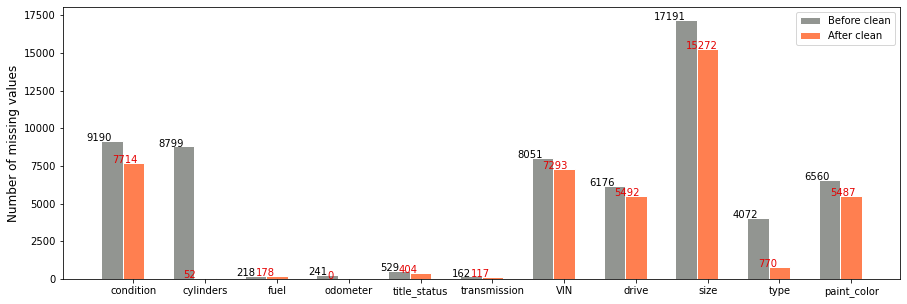

In [11]:
c = clean_df.isnull().sum()
nulls = ecx_data.isnull().sum()
names = ['condition','cylinders','fuel','odometer','title_status',
        'transmission','VIN','drive','size','type','paint_color']

plt.figure(figsize=(15,5))
bar_width = 0.3

r1 = np.arange(len(names))
r2 = [x + bar_width for x in r1]

plt.bar(r1, nulls.loc[names], width=0.3, color='#929591', edgecolor='white', label='Before clean' )
plt.bar(r2, c.loc[names], width=0.3, color='#FF7F50', edgecolor='white', label='After clean')
plt.ylabel('Number of missing values',fontsize=12)

plt.xticks([r + bar_width for r in range(len(names))],names)

for i, name in enumerate(names):
    plt.text(i, nulls.loc[name], str(nulls.loc[name]), color='black',ha='right')
    plt.text(i, c.loc[name], str(c.loc[name]), color='#E50000',ha='left')

plt.legend()
plt.show()

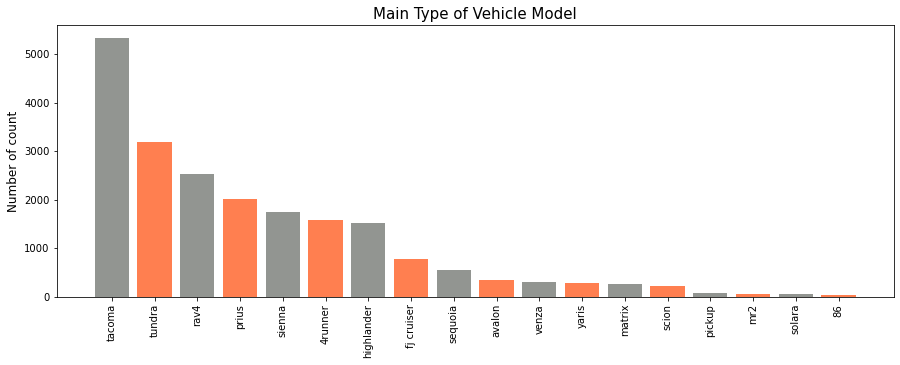

In [12]:
m = clean_df['clean_model'].value_counts()
cmps = ['#929591', '#FF7F50']
plt.figure(figsize=(15,5))
plt.bar(m.index, m , color=cmps)
plt.title('Main Type of Vehicle Model', fontsize = 15 )
plt.ylabel('Number of count',fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.show()

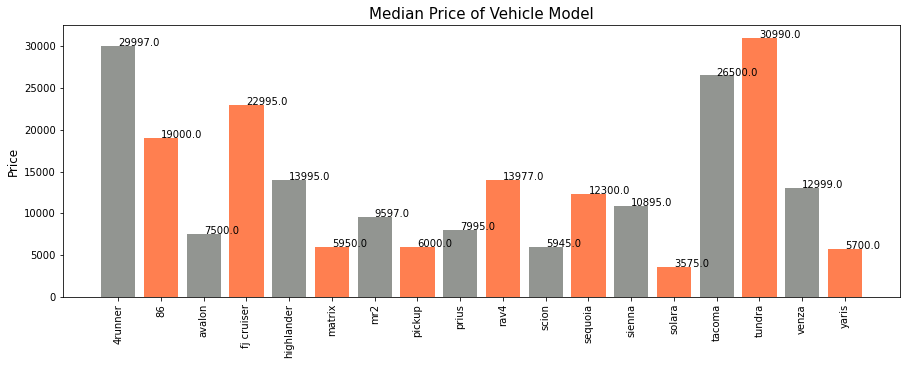

In [13]:
# Show the mdeiam price of each type of vehicle
median = clean_df.groupby(by=['clean_model']).median()['price']

plt.figure(figsize=(15,5))

plt.bar(median.index, median, color=['#929591','#FF7F50'])
plt.title('Median Price of Vehicle Model', fontsize = 15 )
plt.ylabel('Price',fontsize=12)
plt.xticks(rotation=90, fontsize=10)

for idx, val in median.iteritems():
    plt.text(idx, val, str(val), color='black')
        
plt.show()

After completing the whole cleaning process, let's compare the new dataset with the raw dataset.

 - Total size: the original dataset consists of 23549 records, while after cleaning, the new dataset consists of 20900 records.
 
 - Vehicle category: the original 1339 vehicle models are categorized to 18 main type.
 
 - Null values: the comparison of the missing values before and after cleansing has been graphed above. The number of missing values in `cylinders` and `type` columns has dramatically droped based on our filling method.

In addition, the cleaned dataset also become neat on `model` column.

## 3. Feature Engineering

Feature Engineering is also a data preparation process to improve the performance of the ML algorithms.

The feature engineering process in this task includes: feature selection, feature scalling, and categoric features converting.


### 3.1 Feature selection
 
Unnecessary features decrease training speed, decrease model interpretability, and, most importantly, decrease generalization performance on the test set.

There are some simple rules on feature selection:

- Features with a high percentage of missing values
- Collinear (highly correlated) features
- Features with low importance
- Features with a single unique value

Based on these rules, the features `manufacturer` (single unique), `id` and `VIN` (each car has a unique value), and `Sold Date` (all between Apr 2021 to May 2021) are unnecessay features, which could be removed.

Moreover, if the column with a percentage of missing values over 0.1, it's also considered as unecessary features.

In [14]:
# drop features with single or too many unique values
feature_1 = clean_df.drop(columns = ['id','manufacturer','model','VIN','Sold Date','model'])

# drop featuers with a large proportion missing values
pct_missing = feature_1.isnull().sum()
remove_feature = pct_missing[pct_missing > 0.1*(len(feature_1))].index
feature_1 = feature_1.drop(columns=list(remove_feature))
feature_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20900 entries, 0 to 23548
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   price         20900 non-null  int64  
 1   year          20900 non-null  int64  
 2   cylinders     20848 non-null  object 
 3   fuel          20722 non-null  object 
 4   odometer      20900 non-null  float64
 5   title_status  20496 non-null  object 
 6   transmission  20783 non-null  object 
 7   type          20130 non-null  object 
 8   clean_model   20900 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 1.6+ MB


### 3.2 Feature scaling

The machine learning algorithm works on numbers and does not know what that number represents. If there is a vast difference in a column, it makes the underlying assumption that higher ranging numbers have superiority of some sort. 

The raw dataset also presents this problem, for example, the values in `odometer` column spans a large range from 0 to 7 million. Therefore, we should scalling the numeric features to minimize the effect of 'number spans large range'.

The min-max feature scaling meathod was used to scale the numeric features.


In [15]:
def scalling(df, cols):
    scal_df = df.copy()  
    for col in cols:
        max_val = scal_df[col].max()
        min_val = scal_df[col].min()
        scal_df[col] = (scal_df[col] - min_val) / (max_val - min_val)
        
    return  scal_df   

In [16]:
cols = ['price','year','odometer']
feature_2 = scalling(feature_1, cols)

### 3.3 Feature converting

A machine understands only numbers, it does not directly understand letters or text that we as humans can read. That means we need to convert our text and categorical data to numbers.


In [17]:
clean_models = {'clean_model':{'tacoma': 1, 'tundra': 2, 'rav4': 3, 'prius': 4,'sienna': 5,
                               '4runner': 6, 'highlander': 7, 'fj cruiser': 8, 'sequoia': 9,
                               'avalon': 10, 'venza': 11, 'yaris': 12, 'matrix':13,
                               'scion':14, 'pickup': 15, 'mr2':16, 'solara':17, '86': 18 }}

feature_2.replace(clean_models,inplace=True)

In [18]:
# convert categoric features to numberic values
cylinders    = pd.get_dummies(feature_2['cylinders'],prefix='cyd')
fuel         = pd.get_dummies(feature_2['fuel'],prefix='fuel')
title_status = pd.get_dummies(feature_2['title_status'],prefix='ts')
transmission = pd.get_dummies(feature_2['transmission'],prefix='trans')
types        = pd.get_dummies(feature_2['type'],prefix='type')


feature_3  = pd.concat([feature_2, cylinders, fuel, title_status, transmission, types], axis=1)
final_data = feature_3.drop(columns=['cylinders','fuel', 'title_status','transmission','type'])

In [19]:
# generate final data to be used for modelling
final_data.head()

,price,year,odometer,clean_model,cyd_3 cylinders,cyd_4 cylinders,cyd_5 cylinders,cyd_6 cylinders,cyd_8 cylinders,cyd_other,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,0.246132,0.898305,0.011953,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.379649,0.932203,0.004911,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.181736,0.847458,0.021325,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.226085,0.864407,0.018663,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.246989,0.847458,0.012729,6,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4. Modelling

**LightGBM Regression model**: is a fast, distributed, high-performance gradient boosting framework based on decision tree algorithm, which is frequently used for machine learning tasks.

In this section. we will use LightGBM regression model to evaluate the performance on the validation data.




In [20]:
features = list(final_data.columns)
features.remove('price')

train, test = train_test_split(final_data, train_size = 0.8, 
                               test_size = 0.2, random_state = 100)


### 4.1 Hyper-parameters Tuning

Hyperparameter tuning for LightGBM will be completed using 5-fold cross-validation through RandomizedSearchCV.


In [21]:
model = lgb.LGBMRegressor(subsample=0.7)
kf = KFold(n_splits=5,shuffle = True, random_state = 100)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(100, 1500),
          'num_leaves': sp_randint(20, 150),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
model_random = RandomizedSearchCV(model, param_distributions=params, cv=kf, random_state=50, 
                                  scoring='neg_root_mean_squared_error', verbose= 10)
model_random = model_random.fit(train[features], train['price'])

best_params = model_random.best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=170, num_leaves=90
[CV 1/5; 1/10] END colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=170, num_leaves=90;, score=-0.044 total time=   1.8s
[CV 2/5; 1/10] START colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=170, num_leaves=90
[CV 2/5; 1/10] END colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=170, num_leaves=90;, score=-0.041 total time=   1.2s
[CV 3/5; 1/10] START colsample_bytree=0.49460164553802144, learning_rate=0.22808310444933622, max_depth=3, min_child_weight=1.2198762654711293, n_estimators=170, num_leave

In [22]:
lgb_model = lgb.LGBMRegressor(**best_params, subsample=0.7, random_state=50, n_jobs=-1)
lgb_model.fit(train[features], train['price'])

lgb_preds_train = lgb_model.predict(train[features])
lgb_preds_test = lgb_model.predict(test[features])

train_rmse = np.sqrt(mean_squared_error(train['price'], lgb_preds_train))
test_rmse = np.sqrt(mean_squared_error(test['price'], lgb_preds_test))


### 4.2 Model evaluation

Model evaluation is important for us to understand the performance of ML model. 

Root Mean Square Error(RMSE), the standard deviation of the residuals (prediction errors), is a commonly used metric for regression. 

Since the `price` values range from 0 to 1 after scalling, we think the RMSE value between 0.02-0.03 is acceptable.


In [23]:
x = PrettyTable()
x.field_names = ['Model', 'Train RMSE', 'Test RMSE']
x.add_row(['LightGBM', train_rmse, test_rmse])

print(x)

+----------+----------------------+---------------------+
|  Model   |      Train RMSE      |      Test RMSE      |
+----------+----------------------+---------------------+
| LightGBM | 0.025058326111473527 | 0.03419371432163298 |
+----------+----------------------+---------------------+


## 5. Predicting

### 5.1 Preparation

In [24]:
car_code = PrettyTable()

column_names = ['Model', 'Code']                      
car_code.add_column(column_names[0],['tacoma', 'tundra', 'rav4', 'prius', 'sienna',
                    '4runner', 'highlander', 'fj cruiser', 'sequoia', 'avalon',                        
                    'venza', 'yaris', 'matrix','scion', 'pickup', 'mr2', 'solara','86'])
car_code.add_column(column_names[1], [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18])

print(car_code)

+------------+------+
|   Model    | Code |
+------------+------+
|   tacoma   |  1   |
|   tundra   |  2   |
|    rav4    |  3   |
|   prius    |  4   |
|   sienna   |  5   |
|  4runner   |  6   |
| highlander |  7   |
| fj cruiser |  8   |
|  sequoia   |  9   |
|   avalon   |  10  |
|   venza    |  11  |
|   yaris    |  12  |
|   matrix   |  13  |
|   scion    |  14  |
|   pickup   |  15  |
|    mr2     |  16  |
|   solara   |  17  |
|     86     |  18  |
+------------+------+


In [25]:
def input_(year, model, odometer):
    car_cat = {'tacoma': 1, 'tundra': 2, 'rav4': 3, 'prius': 4,'sienna': 5,
               '4runner': 6, 'highlander': 7, 'fj cruiser': 8, 'sequoia': 9,
               'avalon': 10, 'venza': 11, 'yaris': 12, 'matrix':13,
               'scion':14, 'pickup': 15, 'mr2':16, 'solara':17, '86': 18 }
    
    scal_year = (year - feature_1['year'].min()) / (feature_1['year'].max()-feature_1['year'].min())
    scal_odom = (odometer - feature_1['odometer'].min()) / (feature_1['odometer'].max()-feature_1['odometer'].min())
    
    for k, val in car_cat.items():
        if model== k:
            scal_model = val
            
    columns = list(final_data[features].columns) 
    ipt = pd.DataFrame(columns=columns)
    row = {'year': scal_year, 'odometer': scal_odom, 'clean_model': scal_model, 'type_SUV': 1}
    ipt = ipt.append(row, ignore_index=True)
    ipt.fillna(0, inplace=True)
    return ipt

In [26]:
avg_odo = feature_1[(feature_1['clean_model'] == '4runner') & (feature_1['year'] == 2018)]['odometer'].mean()
avg_odo = round(avg_odo,2)
avg_odo

45474.26

### 5.2 Input values
The vehicle's information we will use to predict price is:

- year : 2018
- model: 4runner
- avg_odometer: 45474.26 (calculated based on the original dataset)


In [27]:
inpt = input_(2018, '4runner', avg_odo)
price = lgb_model.predict(inpt)
pred_price =  price*(feature_1['price'].max() - feature_1['price'].min()) + feature_1['price'].min()

### 5.3 Conclusion

In [28]:
c = PrettyTable()

c_column_names=['INPUT', 'OUTPUT']
c.add_column(c_column_names[0],[2018, '4runner', avg_odo])
c.add_column(c_column_names[1],['',round(pred_price[0],0),''])

print(c)

+----------+---------+
|  INPUT   |  OUTPUT |
+----------+---------+
|   2018   |         |
| 4runner  | 41563.0 |
| 45474.26 |         |
+----------+---------+


In [30]:
feature_1[(feature_1['clean_model'] == '4runner') & (feature_1['year'] == 2018) 
              & (feature_1['odometer'] > 41000) & (feature_1['odometer'] < 50000) ][['year','clean_model','price','odometer']]

,year,clean_model,price,odometer
289,2018,4runner,38952,41570.0
484,2018,4runner,43999,48078.0
487,2018,4runner,43999,48078.0
571,2018,4runner,39990,43242.0
576,2018,4runner,39990,43242.0
683,2018,4runner,39990,43242.0
1068,2018,4runner,42999,41572.0
1124,2018,4runner,42999,42400.0
1126,2018,4runner,42999,42400.0
1624,2018,4runner,42999,46199.0


The predicted price of  vehicle -'2018 4runner trd pro, good condition with average km's for their age' is $41,563. 

When listed the vehicles - 2018 4runner with odometer between 41,000 to 45,000 from the previous cleaned dataset, we can see that the predicted price is reasonable.


## 6. Final Solution and Improvements to Existing Approach

Based on the model, the predicted price of '2018 4runner trd pro' is 41563. It is worth noting that due to current surge in used car sales prices and global shortage in vehicle chips, it is forcasted the sale price will continue to rise for used cars. 

The management can adjust this price based on market situation and vehicle management cost, which could lead a price difference. 


There are also some improvements to the exisiting approach to improve the predicted accuray:

- Filling  missing values based on online information, such as vehicle type, cylinders, size, etc.

- Instead of just using 18 main Toyota vehicle models, we can generate features to make detailed classification, such as 'pro', 'limited', etc.